#Import & functions

In [ ]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import shutil
import itertools
import random

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
from os import listdir
from os.path import isfile, join
from PIL import Image
from pathlib import Path
from skimage.color import rgb2gray
import glob
from numpy import savetxt

In [ ]:
pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from patchify import patchify

In [ ]:
def searching_all_files(directory: Path):   
    file_list = [] # A list for storing files existing in directories

    for x in directory.iterdir():
        if x.is_file():

           file_list.append(str(x))
        else:

           file_list.append(searching_all_files(directory/x))

    return file_list

In [ ]:
def flatten(listOfLists):
    "Flatten one level of nesting"
    return list(itertools.chain.from_iterable(listOfLists))

In [ ]:
def norm_HnE(img, Io=240, alpha=1, beta=0.15):


    ######## Step 1: Convert RGB to OD ###################
    ## reference H&E OD matrix.
    #Default values. 
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    ### reference maximum stain concentrations for H&E
    maxCRef = np.array([1.9705, 1.0308])
    
    
    # extract the height, width and num of channels of image
    h, w, c = img.shape
    
    # reshape image to multiple rows and 3 columns.
    #Num of rows depends on the image size (wxh)
    img = img.reshape((-1,3))
    
    
    OD = -np.log10((img.astype(np.float)+1)/Io) #Use this for opencv imread
    #Add 1 in case any pixels in the image have a value of 0 (log 0 is indeterminate)
    
    
    ############ Step 2: Remove data with OD intensity less than β ############
    # remove transparent pixels (clear region with no tissue)
    ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
    #Check by printing ODhat.min()
    
    ############# Step 3: Calculate SVD on the OD tuples ######################
    #Estimate covariance matrix of ODhat (transposed)
    # and then compute eigen values & eigenvectors.
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    
    ######## Step 4: Create plane from the SVD directions with two largest values ######
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3]) #Dot product
    
    ############### Step 5: Project data onto the plane, and normalize to unit length ###########
    ############## Step 6: Calculate angle of each point wrt the first SVD direction ########
    #find the min and max vectors and project back to OD space
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:    
        HE = np.array((vMin[:,0], vMax[:,0])).T
        
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    ###### Step 8: Convert extreme values back to OD space
    # recreate the normalized image using reference mixing matrix 
    
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # Separating H and E components
    
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    return (Inorm, H, E)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Parameters

In [ ]:
num_img = 100 # change to 200 to run ccRCC + pRCC
num_img_test = 5 # change to 10 to run ccRCC + pRCC
pre_processing = False
HE = True

# patch_size = 256 # remove comment to create patches

#Loading Roodir


In [ ]:
#TRAIN
rootdir = "/content/drive/MyDrive/Bioinfo/Dataset/Train"
rootdir = Path(rootdir)
onlyfiles = searching_all_files(rootdir)

#TEST
rootdirTest = "/content/drive/MyDrive/Bioinfo/Dataset/Test"
rootdirTest = Path(rootdirTest)
onlyfilesTest = searching_all_files(rootdirTest)

In [ ]:
#TRAIN
onlyfiles_twoClass = flatten(onlyfiles)
onlyfiles_patient = flatten(onlyfiles_twoClass)
onlyfiles_all = flatten(onlyfiles_patient)

#TEST
onlyfiles_all_test = flatten(onlyfilesTest)

In [ ]:
#Directory division root original and masks:
#TRAIN
root_originals = []
root_masks_segm = []

for root_img in onlyfiles_all:
  #if "seg" not in root_img and "png" in root_img: # remove the comment to run ccRCC + pRCC
  #if "seg" not in root_img and "png" in root_img and "ccRCC" in root_img: # remove the comment to run ccRCC
  if "seg" not in root_img and "png" in root_img and "pRCC" in root_img: # remove the comment to run pRCC
    root_originals.append(root_img)
  #elif "seg" in root_img and "png" in root_img: # remove the comment to run ccRCC + pRCC
  #elif "seg" in root_img and "png" in root_img and "ccRCC" in root_img: # remove the comment to run ccRCC
  elif "seg" in root_img and "png" in root_img and "pRCC" in root_img: # remove the comment to run pRCC
    root_masks_segm.append(root_img)


#TEST:
root_originals_test = []
root_masks_segm_test = []

for root_img_test in onlyfiles_all_test:
  #if "seg" not in root_img_test and "png" in root_img_test:  # remove the comment to run ccRCC + pRCC
  if "seg" not in root_img_test and "png" in root_img_test and "ccRCC" in root_img_test: # remove the comment to run ccRCC
  if "seg" not in root_img_test and "png" in root_img_test and "pRCC" in root_img_test:  # remove the comment to run pRCC
    root_originals_test.append(root_img_test)
  #elif "seg" in root_img_test and "png" in root_img_test: # remove the comment to run ccRCC + pRCC
  elif "seg" in root_img_test and "png" in root_img_test and "pRCC" in root_img_test: # remove the comment to run ccRCC
  elif "seg" in root_img_test and "png" in root_img_test and "pRCC" in root_img_test: # remove the comment to run pRCC
    root_masks_segm_test.append(root_img_test)

In [ ]:
#TRAIN
root_originals.sort()
root_masks_segm.sort()

#TEST
root_originals_test.sort()
root_masks_segm_test.sort()

# Loading PATCH in folders and saving numpy


TRAIN

In [ ]:
'''filesTrain = glob.glob('/content/drive/MyDrive/Bioinfo/Dataset/TrainOriginalPatch/*')
for f in filesTrain:
    os.remove(f)
filesTest = glob.glob('/content/drive/MyDrive/Bioinfo/Dataset/TrainMaskPatch/*')
for f in filesTest:
    os.remove(f)

root_originals_sub = root_originals[0:num_img]
number = 0
for path_original in root_originals_sub:
  number = number + 1 
  img = cv2.imread(path_original,1)
  #img = cv2.resize(img, None, fx = 0.512, fy = 0.512, interpolation = cv2.INTER_CUBIC) 
  patches_img = patchify(img, (patch_size,patch_size,3), step = patch_size)

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,0,:,:,:]
      cv2.imwrite('/content/drive/MyDrive/Bioinfo/Dataset/TrainOriginalPatch/'+'image'+str(number)+'_'+str(i)+str(j)+'.png', single_patch_img)


root_masks_segm_sub = root_masks_segm[0:num_img]
number = 0
for path_segmentation in root_masks_segm_sub:
  number = number + 1
  img = cv2.imread(path_segmentation,0)
  (thresh, blackAndWhiteImg) = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
  #img = cv2.resize(img, None, fx = 0.512, fy = 0.512, interpolation = cv2.INTER_CUBIC) 
  patches_img = patchify(blackAndWhiteImg, (patch_size,patch_size), step = patch_size)

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,:,:]
      cv2.imwrite('/content/drive/MyDrive/Bioinfo/Dataset/TrainMaskPatch/'+'image'+str(number)+'_'+str(i)+str(j)+'.png', single_patch_img)'''

TEST

In [ ]:
'''filesTrain = glob.glob('/content/drive/MyDrive/Bioinfo/Dataset/TestOriginalPatch/*')
for f in filesTrain:
    os.remove(f)
filesTest = glob.glob('/content/drive/MyDrive/Bioinfo/Dataset/TestMaskPatch/*')
for f in filesTest:
    os.remove(f)


number = 0
for path_original in root_originals_test[0:num_img_test]:
  number = number + 1 
  img = cv2.imread(path_original,1)
  #img = cv2.resize(img, None, fx = 0.512, fy = 0.512, interpolation = cv2.INTER_CUBIC) 
  patches_img = patchify(img, (patch_size,patch_size,3), step = patch_size)

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,0,:,:,:]
      cv2.imwrite('/content/drive/MyDrive/Bioinfo/Dataset/TestOriginalPatch/'+'image'+str(number)+'_'+str(i)+str(j)+'.png', single_patch_img)


number = 0
for path_segmentation in root_masks_segm_test[0:num_img_test]:
  number = number + 1
  img = cv2.imread(path_segmentation,0)
  (thresh, blackAndWhiteImg) = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
  #img = cv2.resize(img, None, fx = 0.512, fy = 0.512, interpolation = cv2.INTER_CUBIC) 
  patches_img = patchify(blackAndWhiteImg, (patch_size,patch_size), step = patch_size)

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,:,:]
      cv2.imwrite('/content/drive/MyDrive/Bioinfo/Dataset/TestMaskPatch/'+'image'+str(number)+'_'+str(i)+str(j)+'.png', single_patch_img)'''

In [ ]:
'''img_names = glob.glob('/content/drive/MyDrive/Bioinfo/Dataset/TrainOriginalPatch/*.png')
img_names.sort()
mask_names = glob.glob('/content/drive/MyDrive/Bioinfo/Dataset/TrainMaskPatch/*.png')
mask_names.sort()


original = []

def gen_images_original():
    for path_original in img_names:
        img = cv2.imread(path_original,1)[:,:,::-1]
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        yield img

for image in gen_images_original():
    original.append(image)
    
original_dataset = np.array(original)


segmentation = []

def gen_images_mask():
    for path_original in mask_names:
        lab = cv2.imread(path_original,0)
        lab = cv2.normalize(lab, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        yield lab

for image in gen_images_mask():
    segmentation.append(image)

segm_dataset = np.array(segmentation)
segm_dataset = np.expand_dims(segm_dataset, axis=3)


np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Patches/train_original.npy', original_dataset)
np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Patches/train_mask.npy', segm_dataset)

img_names_test = glob.glob('/content/drive/MyDrive/Bioinfo/Dataset/TestOriginalPatch/*.png')
img_names_test.sort()
mask_names_test = glob.glob('/content/drive/MyDrive/Bioinfo/Dataset/TestMaskPatch/*.png')
mask_names_test.sort()


original_test = []
for path_original in img_names_test:
  img = cv2.imread(path_original,1)[:,:,::-1]
  img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  original_test.append(img)

original_dataset_test = np.array(original_test)


segmentation_test = []
for path_original in mask_names_test:
  
  img = cv2.imread(path_original,0)
  img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  segmentation_test.append(img)

segm_dataset_test = np.array(segmentation_test)
segm_dataset_test = np.expand_dims(segm_dataset_test, axis=3)

np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Patches/test_original.npy', original_dataset_test)
np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Patches/test_mask.npy', segm_dataset_test)'''

# Loading dataset (mask-original)

In [ ]:
if HE:
  root_originals_sub = root_originals[0:num_img]
  original = []
  original_H = []
  original_E = []
  original_norm = []

  for path_original in root_originals_sub:
    img = cv2.imread(path_original,1)[:,:,::-1]
    img = cv2.resize(img, None, fx = 0.128, fy = 0.128, interpolation = cv2.INTER_CUBIC)

    norm_img, H_img, E_img = norm_HnE(img, Io=240, alpha=1, beta=0.15)
    original.append(img)
    original_H.append(H_img)
    original_E.append(E_img)
    original_norm.append(norm_img)

  

  original_dataset = np.array(original)
  H_dataset = np.array(original_H)
  E_dataset = np.array(original_E)
  norm_dataset = np.array(original_norm)
  
  
  #______________________________________________________________________________
  #TEST

  original_test = []
  original_H_test = []
  original_E_test = []
  original_norm_test = []
  
  for path_original in root_originals_test[0:num_img_test]:
    img = cv2.imread(path_original,1)[:,:,::-1]
    img = cv2.resize(img, None, fx = 0.128, fy = 0.128, interpolation = cv2.INTER_CUBIC)

    norm_img, H_img, E_img = norm_HnE(img, Io=240, alpha=1, beta=0.15)
    original_test.append(img)
    original_H_test.append(H_img)
    original_E_test.append(E_img)
    original_norm_test.append(norm_img)

  original_dataset_test = np.array(original_test)
  H_dataset_test = np.array(original_H_test)
  E_dataset_test = np.array(original_E_test)
  norm_dataset_test = np.array(original_norm_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
def plot_hist(l):
  plt.figure(figsize=(7, 4))
  plt.hist(l.flat, bins=100, range=(0,255))
  plt.show()

In [ ]:
if pre_processing:
  root_originals_sub = root_originals[0:num_img]
  original = []
  equalized = []
  clahed = []

  i = 0
  for path_original in root_originals_sub:
    i = i + 1
    img = cv2.imread(path_original,1)
    img = cv2.resize(img, None, fx = 0.128, fy = 0.128, interpolation = cv2.INTER_CUBIC)


    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b, = cv2.split(lab_img)

    #plot_hist(l)

    equ = cv2.equalizeHist(l)

    #plot_hist(equ)

    updated_lab_img = cv2.merge((equ, a, b))
    hist_eq_img = cv2.cvtColor(updated_lab_img, cv2.COLOR_LAB2BGR)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(l)

    #plot_hist(clahe_img)

    updated_lab_img2 = cv2.merge((clahe_img, a, b))
    CLAHE_img = cv2.cvtColor(updated_lab_img2, cv2.COLOR_LAB2BGR)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hist_eq_img = cv2.cvtColor(hist_eq_img, cv2.COLOR_BGR2RGB)
    CLAHE_img = cv2.cvtColor(CLAHE_img, cv2.COLOR_BGR2RGB)

    original.append(img)
    equalized.append(hist_eq_img)
    clahed.append(CLAHE_img)

  original_dataset = np.array(original)
  equalized_dataset = np.array(equalized)
  clahed_dataset = np.array(clahed)
  

  #______________________________________________________________________________
  #TEST

  original_test = []
  equalized_test = []
  clahed_test = []
  
  for path_original in root_originals_test[0:num_img_test]:
    img = cv2.imread(path_original,1)
    img = cv2.resize(img, None, fx = 0.128, fy = 0.128, interpolation = cv2.INTER_CUBIC) 
    
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b, = cv2.split(lab_img)
    equ = cv2.equalizeHist(l)

    updated_lab_img = cv2.merge((equ, a, b))
    hist_eq_img = cv2.cvtColor(updated_lab_img, cv2.COLOR_LAB2BGR)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(l)
    updated_lab_img2 = cv2.merge((clahe_img, a, b))
    CLAHE_img = cv2.cvtColor(updated_lab_img2, cv2.COLOR_LAB2BGR)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hist_eq_img = cv2.cvtColor(hist_eq_img, cv2.COLOR_BGR2RGB)
    CLAHE_img = cv2.cvtColor(CLAHE_img, cv2.COLOR_BGR2RGB)

    original_test.append(img)
    equalized_test.append(hist_eq_img)
    clahed_test.append(CLAHE_img)

  original_dataset_test = np.array(original_test)
  equalized_dataset_test = np.array(equalized_test)
  clahed_dataset_test = np.array(clahed_test)

In [ ]:
if pre_processing:
  import random

  image_number = random.randint(0, len(original_dataset)-1)
  image_number = 32
  plt.figure(figsize=(12, 6))
  plt.subplot(131)
  plt.imshow(original_dataset[image_number,:,:,:])
  plt.subplot(132)
  plt.imshow(equalized_dataset[image_number,:,:,:])
  plt.subplot(133)
  plt.imshow(clahed_dataset[image_number,:,:,:])

  plt.show()

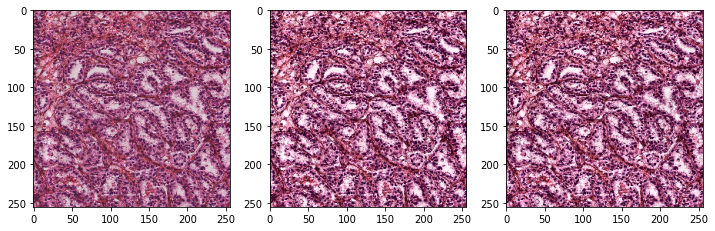

In [ ]:
if pre_processing:
  import random

  image_number = random.randint(0, len(original_dataset_test)-1)
  plt.figure(figsize=(12, 6))
  plt.subplot(131)
  plt.imshow(original_dataset_test[image_number,:,:,:])
  plt.subplot(132)
  plt.imshow(equalized_dataset_test[image_number,:,:,:])
  plt.subplot(133)
  plt.imshow(clahed_dataset_test[image_number,:,:,:])

  plt.show()

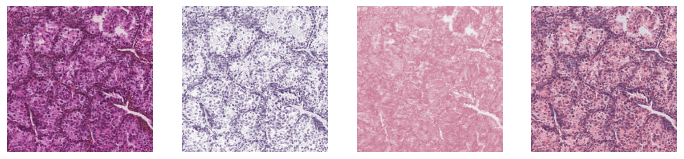

32


In [ ]:
if HE:
  import random

  image_number = random.randint(0, len(original_dataset)-1)
  plt.figure(figsize=(12, 6))
  plt.subplot(141)
  plt.imshow(original_dataset[image_number,:,:,:])
  plt.subplot(142)
  plt.imshow(H_dataset[image_number,:,:,:])
  plt.subplot(143)
  plt.imshow(E_dataset[image_number,:,:,:])
  plt.subplot(144)
  plt.imshow(norm_dataset[image_number,:,:,:])

  plt.show()

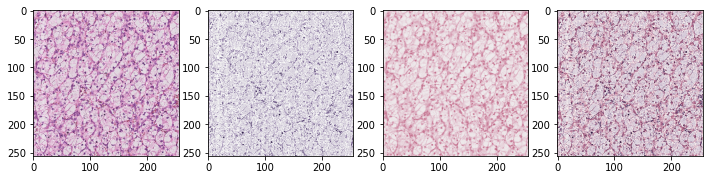

In [ ]:
if HE:
  import random

  image_number = random.randint(0, len(original_dataset_test)-1)
  plt.figure(figsize=(12, 6))
  plt.subplot(141)
  plt.imshow(original_dataset_test[image_number,:,:,:])
  plt.subplot(142)
  plt.imshow(H_dataset_test[image_number,:,:,:])
  plt.subplot(143)
  plt.imshow(E_dataset_test[image_number,:,:,:])
  plt.subplot(144)
  plt.imshow(norm_dataset_test[image_number,:,:,:])

  plt.show()

In [ ]:
if pre_processing == False and HE == False:
  root_originals_sub = root_originals[0:num_img]
  original = []
  for path_original in root_originals_sub:
    img = cv2.imread(path_original,1)[:,:,::-1]
    img = cv2.resize(img, None, fx = 0.128, fy = 0.128, interpolation = cv2.INTER_CUBIC) 
    original.append(img)

  original_dataset = np.array(original)

  #_______________________________________________________________________________
  #TEST
  #_______________________________________________________________________________


  original_test = []
  for path_original in root_originals_test[0:num_img_test]:
    img = cv2.imread(path_original,1)[:,:,::-1]
    img = cv2.resize(img, None, fx = 0.128, fy = 0.128, interpolation = cv2.INTER_CUBIC) 
    original_test.append(img)

  original_dataset_test = np.array(original_test)

In [ ]:
root_masks_segm_sub = root_masks_segm[0:num_img]
segmentation = []
for path_segmentation in root_masks_segm_sub:
  img = cv2.imread(path_segmentation,0)
  img = cv2.resize(img, None, fx = 0.128, fy = 0.128, interpolation = cv2.INTER_CUBIC)
  (thresh, blackAndWhiteImg) = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
  segmentation.append(blackAndWhiteImg)

segm_dataset = np.array(segmentation)
segm_dataset = np.expand_dims(segm_dataset, axis=3)


#________________________________________________________________________________
#TEST
#_________________________________________________________________________________

segmentation_test = []
for path_segmentation in root_masks_segm_test[0:num_img_test]:
  img = cv2.imread(path_segmentation,0)
  img = cv2.resize(img, None, fx = 0.128, fy = 0.128, interpolation = cv2.INTER_CUBIC)
  (thresh, blackAndWhiteImg) = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
  segmentation_test.append(blackAndWhiteImg)

segm_dataset_test = np.array(segmentation_test)
segm_dataset_test = np.expand_dims(segm_dataset_test, axis=3)

In [ ]:
if pre_processing:
  # TRAIN
  original_dataset = original_dataset/255.
  equalized_dataset = equalized_dataset/255.
  clahed_dataset = clahed_dataset/255.
  segm_dataset = segm_dataset/255.


  #TEST
  original_dataset_test = original_dataset_test/255.
  equalized_dataset_test = equalized_dataset_test/255.
  clahed_dataset_test = clahed_dataset_test/255.
  segm_dataset_test = segm_dataset_test/255.

In [ ]:
if HE:
  # TRAIN
  original_dataset = original_dataset/255.
  norm_dataset = norm_dataset/255.
  segm_dataset = segm_dataset/255.


  #TEST
  original_dataset_test = original_dataset_test/255.
  norm_dataset_test = norm_dataset_test/255.
  segm_dataset_test = segm_dataset_test/255.

In [ ]:
if pre_processing == False and HE == False:
  # TRAIN
  original_dataset = original_dataset/255.
  segm_dataset = segm_dataset/255.


  #TEST
  original_dataset_test = original_dataset_test/255.
  segm_dataset_test = segm_dataset_test/255.

In [ ]:
print("shape: ",original_dataset.shape)
print("segm shape: ", segm_dataset.shape)
print("test shape: ", segm_dataset_test.shape)
print("segm test shape: ", original_dataset_test.shape)

shape:  (100, 256, 256, 3)
segm shape:  (100, 256, 256, 1)
test shape:  (5, 256, 256, 1)
segm test shape:  (5, 256, 256, 3)


In [ ]:
if pre_processing:
  np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/train_Pr_equalized',equalized_dataset)
  np.save('/content/drive/MyDrive/Bioinfo/Dataset/Original/train_Pr_clahed',clahed_dataset)
  np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/test_Pr_equalized',equalized_dataset_test)
  np.save('/content/drive/MyDrive/Bioinfo/Dataset/Original/test_Pr_clahed',clahed_dataset_test)

In [ ]:
if HE:
  np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/train_Pr_norm',norm_dataset)
  np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/test_Pr_norm',norm_dataset_test)
  np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/train_Pr_mask_BIN',segm_dataset)
  np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/test_Pr_mask_BIN',segm_dataset_test)

In [ ]:
if pre_processing == False and HE == False:
  np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/train_Pr_original',original_dataset)
  np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Original/test_Pr_original',original_dataset_test)
  np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/train_Pr_mask_BIN',segm_dataset)
  np.save('/content/drive/MyDrive/Bioinfo/Dataset_numpy/Mask/test_Pr_mask_BIN',segm_dataset_test)